In [2]:
'''
Import the necessary libraries:
os: to work with file directories
numpy: to work with arrays
pylab:
glob: to find for particular files
scipy.io: to load and save .mat files
data_import: to access the .txt data
rsync: to align the data
'''

import os
import numpy as np
# import pylab as plt
import glob as glob
from scipy.io import loadmat, savemat
import data_import as di
from rsync import Rsync_aligner
from tkinter import *
from tkinter import filedialog

In [3]:
# Define the samping frequency
sampling_frequency = 30e3

In [4]:
# Define a function to
directory_object = Tk()
directory_object.withdraw()
project_file_directory = filedialog.askdirectory()

In [5]:
project_file_directory
project_file_directory = os.path.join(project_file_directory,'SpikeStuff')

In [6]:
all_folders_names = next(os.walk(project_file_directory))[1]

In [7]:
all_folders_names

['ES', 'Control']

In [8]:
def check_if_directory_exists(directory_fun):
    if not os.path.isdir(directory_fun):
        os.mkdir(directory_fun)

/home/cresp1el-local/Documents/MATLAB/Rbp4_TestCase/SpikeStuff/ES
There are 1 number of .txt files to extract data from ES folder.

Extracting data from file path: /home/cresp1el-local/Documents/MATLAB/Rbp4_TestCase/SpikeStuff/ES/ctz_3731_rbp4_led-2022-11-05-142607.txt
Importing data file: ctz_3731_rbp4_led-2022-11-05-142607.txt
Extracting from /home/cresp1el-local/Documents/MATLAB/Rbp4_TestCase/SpikeStuff/ES/MUA/ctz_3731_rbp4_led/allData/timestamp_ms_nev.mat
ctz_3731_rbp4_led: Rsync_PC and timestamp_ms_nev shapes are fine!
Rsync has 190 elements and timestamp_ms_nev has 190 elements.
-------------------------------------------------------------------------------------------------------
/home/cresp1el-local/Documents/MATLAB/Rbp4_TestCase/SpikeStuff/Control
There are 1 number of .txt files to extract data from Control folder.

Extracting data from file path: /home/cresp1el-local/Documents/MATLAB/Rbp4_TestCase/SpikeStuff/Control/veh_3061_rbp4_led-2022-11-02-141747.txt
Importing data file

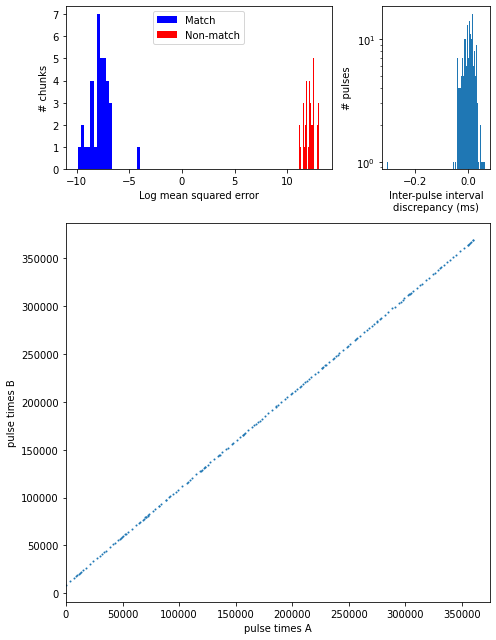

In [9]:
for n_folder in range(len(all_folders_names)):
    particular_project_folder = project_file_directory + "/" + all_folders_names[n_folder]
    print(particular_project_folder)
    
    find_for_txt_files = particular_project_folder + "/*.txt"
    txt_file_full_paths = glob.glob(find_for_txt_files)

    total_txt_files = len(txt_file_full_paths)
    print("There are %d number of .txt files to extract data from %s folder." 
          %(total_txt_files, all_folders_names[n_folder]))

    ns6_file_names = []
    txt_file_names = []

    for files in os.listdir(particular_project_folder):
        # Check if the given path is a file
        if os.path.isfile(os.path.join(particular_project_folder, files)):
            # Check if the file ends with a ".txt" extension
            if files.endswith(".ns6"):
                ns6_file_names.append(files)
                
    for files in os.listdir(particular_project_folder):
        # Check if the given path is a file
        if os.path.isfile(os.path.join(particular_project_folder, files)):
            # Check if the file ends with a ".txt" extension
            if files.endswith(".txt"):
                txt_file_names.append(files)
    
    # This is to ensure files do not read in an unorganized manner
    ns6_file_names = np.sort(ns6_file_names)
    txt_file_names = np.sort(txt_file_names)
    
    for n_txt_files in range(total_txt_files):
        particular_txt_file_path = particular_project_folder + "/" + txt_file_names[n_txt_files]
        
        # Check if MUA exists within the project folder
        file_directory_to_save_data = particular_project_folder + "/MUA/"
        check_if_directory_exists(file_directory_to_save_data)
        
        file_directory_to_save_data = file_directory_to_save_data + ns6_file_names[n_txt_files][:-4]
        check_if_directory_exists(file_directory_to_save_data)
        
        file_directory_to_save_data = file_directory_to_save_data + "/allData/"
        check_if_directory_exists(file_directory_to_save_data)
                
        print("\nExtracting data from file path: %s" % particular_txt_file_path)
        PC_data = di.Session(particular_txt_file_path, int_subject_IDs=False)
        
        session_events= PC_data.events
        session_times = PC_data.times
        session_print_lines = PC_data.print_lines
        
        savemat(file_directory_to_save_data + "session_events.mat", {"data": session_events})
        savemat(file_directory_to_save_data + "session_times.mat", {"data": session_times})
        savemat(file_directory_to_save_data + "session_print_lines.mat", {"data": session_print_lines})
        
        # Extract data from ".txt" file
        rsync_PC = PC_data.times["rsync"]
        stim_active_PC = PC_data.times["stim_active"]
        
        # Extract data from the ".nev" saved as a ".mat" file
        
        extract_nev_file_data_from = particular_project_folder + "/MUA/" + ns6_file_names[n_txt_files][:-4] + "/allData/"
        timestamp_nev_file_directory = extract_nev_file_data_from + "timestamp_ms_nev.mat"
        print("Extracting from %s" %timestamp_nev_file_directory)
        timestamp_ms_dict = loadmat(timestamp_nev_file_directory)
        
        timestamp_ms_nev = timestamp_ms_dict["timestamp_ms"][0]
        
        timestamp_ms_nev = np.reshape(timestamp_ms_nev, (len(timestamp_ms_nev), ))
        
        if len(rsync_PC) == len(timestamp_ms_nev)/2:
                timestamp_ms_nev = timestamp_ms_nev[0::2]
        
        pulse_times_PC = rsync_PC
        pulse_timestamps_BR = timestamp_ms_nev
        
        try:
            ephys_aligner = Rsync_aligner(pulse_times_A=pulse_times_PC, pulse_times_B=pulse_timestamps_BR,
                        units_A="auto", units_B="auto", plot=True)
            print("%s: Rsync_PC and timestamp_ms_nev shapes are fine!" %ns6_file_names[n_txt_files][:-4])
            print("Rsync has %d elements and timestamp_ms_nev has %d elements." 
                  %(len(rsync_PC), len(timestamp_ms_nev)))
            
        except:
            print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            print("%s: Check rsync_PC and timestamp_ms_nev shapes!" %ns6_file_names[n_txt_files][:-4])
            print("Rsync has %d elements and timestamp_ms_nev has %d elements." 
                  %(len(rsync_PC), len(timestamp_ms_nev)))
            print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            
        num_trials = len(stim_active_PC)
        reward_times = PC_data.times['stim_active'][:num_trials]
        onsets = ephys_aligner.A_to_B(reward_times).astype(int)
        
        reward_times = PC_data.times['waiting_period'][:num_trials]
        offsets = ephys_aligner.A_to_B(reward_times).astype(int)
        
        ## comment add what Manny just said]Py control is initialized you get square shaped artifact
        if onsets[0] > offsets[0]:
            modified_onsets = onsets[:-1]
            modified_offsets = offsets[1:]
        
            all_timestamp_ms = np.zeros((len(modified_onsets), 3))

            all_timestamp_ms[:, 0] = modified_onsets # ms
            all_timestamp_ms[:, 1] = modified_offsets # ms
            
        else:
            all_timestamp_ms = np.zeros((len(onsets), 3))

            all_timestamp_ms[:, 0] = onsets # ms
            all_timestamp_ms[:, 1] = offsets # ms
        
        savemat(file_directory_to_save_data + 'without_frequency_timestamp_ms.mat', {'data': all_timestamp_ms})
            
    print("-------------------------------------------------------------------------------------------------------")